In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## 데이터 준비

In [2]:
train_path = '../data/cityscapes/train/'
val_path = '../data/cityscapes/val/'

In [3]:
print("number of train data :", len(os.listdir(train_path)))
print("number of validation data :", len(os.listdir(val_path)))

number of train data : 1000
number of validation data : 5


In [4]:
sample_image = tf.io.read_file(train_path + '1.jpg')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)  # 256 x 256 이미지 2개가 합쳐진 256 x 512

(256, 512, 3)


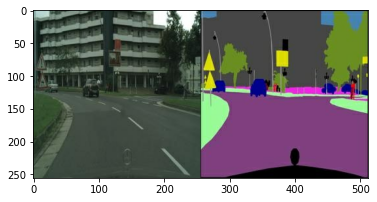

In [5]:
plt.figure()
plt.imshow(sample_image)

In [6]:
# 실제 이미지와 segmentation map 이미지를 분리하는 함수
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]
    
    # Convert both images to float32
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

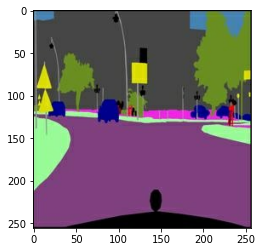

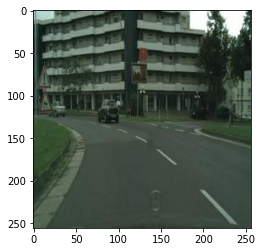

In [7]:
# segmentation 이미지와 실제 이미지 분리

inp, re = load(train_path + '1.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

pix2pix 논문에 설명된 대로 훈련 세트를 전처리 하기 위해 랜덤 지터링과 미러링를 적용해야함.

다음과 같은 여러 함수를 정의.

1. 각 256 x 256 이미지의 크기를 더 큰 높이와 너비(286 x 286) 로 조정.
2. 무작위로 다시 256 x 256 으로 자르기.
3. 이미지를 가로로 무작위로 뒤집기(예: 왼쪽에서 오른쪽으로 임의 미러링).
4. 이미지를 [-1, 1] 범위로 정규화.

In [8]:
# The facade training set consist of 1000 images
BUFFER_SIZE = 1000
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

#tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

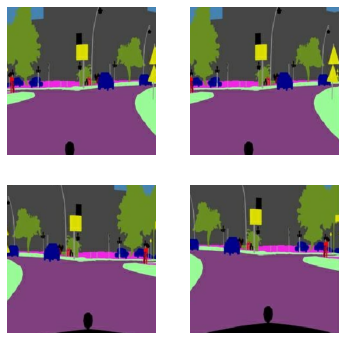

In [10]:
# 전처리가 잘 진행됬는지 체크

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

## tf.data로 입력 파이프라인 구축하기

In [12]:
train_dataset = tf.data.Dataset.list_files(train_path + '*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(val_path + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Generator

In [13]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
    
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
    
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


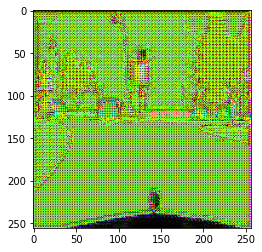

In [15]:
# 생성기 테스트

generator = UNetGenerator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Discriminator

In [16]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
    
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
        
        if self.use_bn:
            x = self.batchnorm(x)
        
        if self.act:
            x = self.lrelu(x)
        return x

In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [18]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_14[0][0]       

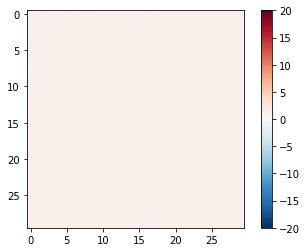

In [19]:
# 판별자 테스트

discriminator = Discriminator()
disc_out = discriminator(inp[tf.newaxis, ...], gen_output, training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Loss & Optimizer

In [20]:
# loss 설정 

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [21]:
# optimizer 설정

gene_opt = optimizers.Adam(2e-4, beta_1=.5)
disc_opt = optimizers.Adam(2e-4, beta_1=.5)

In [22]:
# 학습도중 뜻하지 않게 멈출것을 고려하여 체크포인트 설정

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                discriminator_optimizer=disc_opt,
                                generator=generator,
                                discriminator=discriminator)

## 이미지 출력함수

In [23]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    
    display_list = [test_input[0], prediction[0], tar[0]]
    title = ['Input Image', 'Predicted Image', 'Ground Truth']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


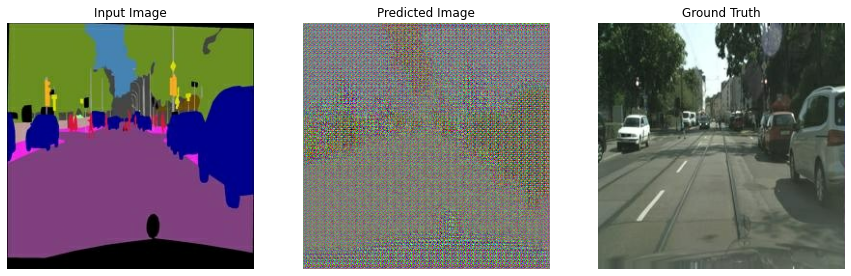

In [24]:
# 이미지 출력 함수 테스트

for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## 모델 훈련

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 lambda=100
        
        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
    
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [26]:
EPOCHS = 50
history = {'g_loss': [], 'l1_loss': [], 'd_loss': []}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_dataset):
        for j in zip(history, train_step(sketch, colored)): history[j[0]] += [round(j[1].numpy(), 4)]
        
        # 250회 반복마다 손실 출력.
        if (i+1) %  250 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{history['g_loss'][-1]:.4f} \
                    \nL1_loss:{history['l1_loss'][-1]:.4f} \
                    \nDiscriminator_loss:{history['d_loss'][-1]:.4f}", end="\n\n")
    # EPOCHS 10회 마다 체크포인트 저장.
    if (epoch+1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

EPOCH[1] - STEP[250]                     
Generator_loss:1.7812                     
L1_loss:0.1506                     
Discriminator_loss:0.8911

EPOCH[1] - STEP[500]                     
Generator_loss:1.4469                     
L1_loss:0.1776                     
Discriminator_loss:0.8986

EPOCH[1] - STEP[750]                     
Generator_loss:1.9161                     
L1_loss:0.1918                     
Discriminator_loss:1.4506

EPOCH[1] - STEP[1000]                     
Generator_loss:0.9502                     
L1_loss:0.1663                     
Discriminator_loss:0.8590

EPOCH[2] - STEP[250]                     
Generator_loss:1.8133                     
L1_loss:0.1913                     
Discriminator_loss:0.2335

EPOCH[2] - STEP[500]                     
Generator_loss:1.0261                     
L1_loss:0.1314                     
Discriminator_loss:0.8357

EPOCH[2] - STEP[750]                     
Generator_loss:0.9223                     
L1_loss:0.1775            

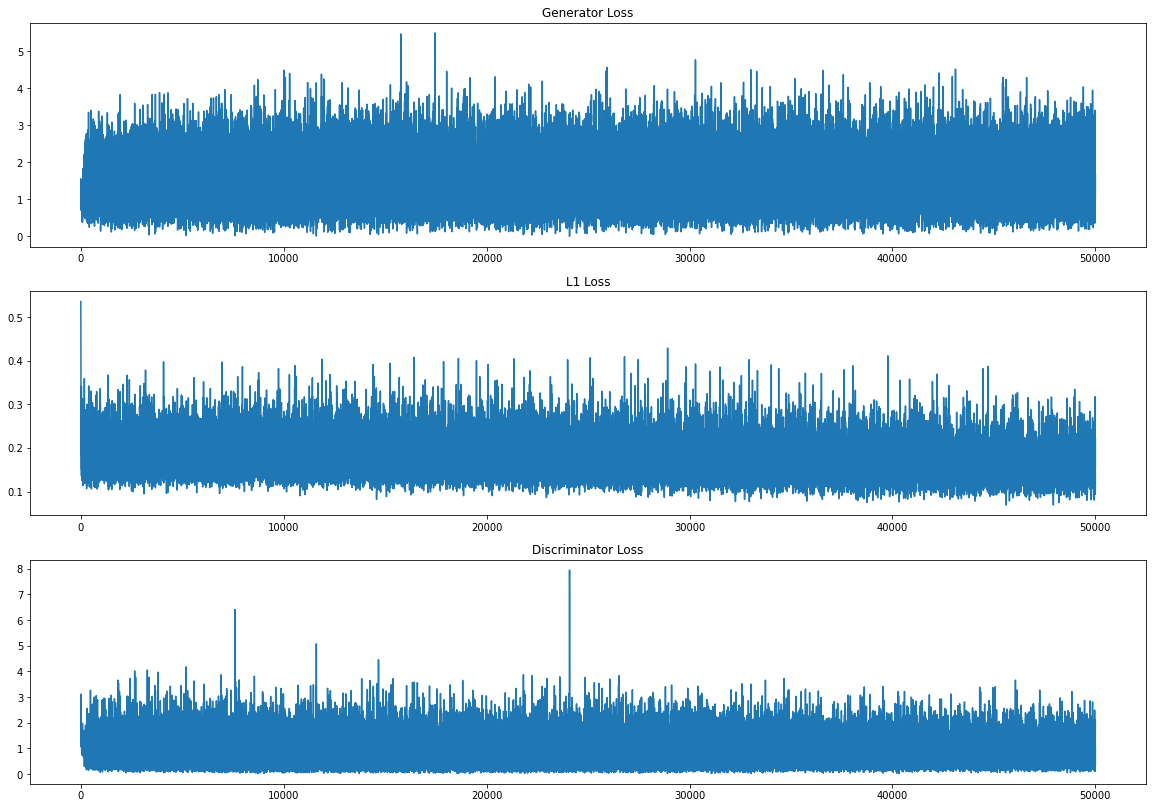

In [27]:
# loss 보기편하게 시각화

c_title = ['Generator Loss', 'L1 Loss', 'Discriminator Loss']
plt.figure(figsize=(20, 14))

for i, j in enumerate(zip(history, c_title), start=311):
    plt.subplot(i)
    plt.plot(history[j[0]])
    plt.title(j[1])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


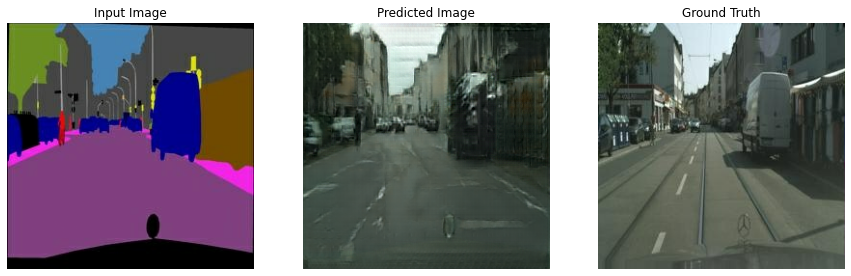

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


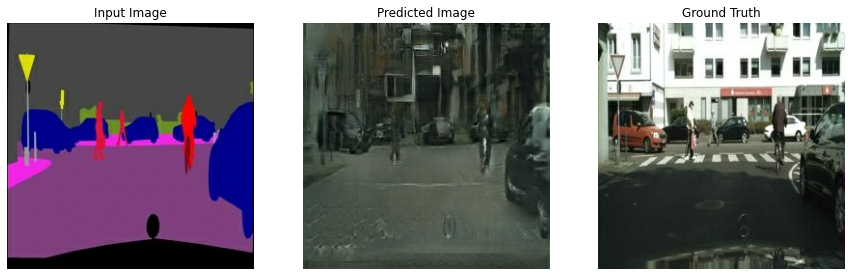

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


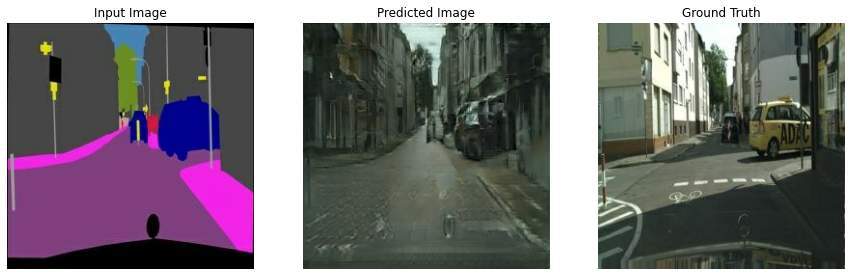

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


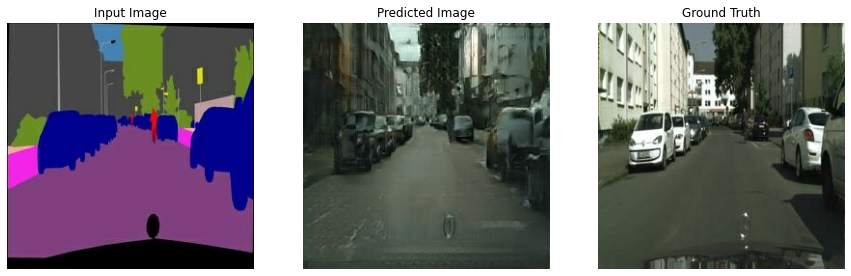

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


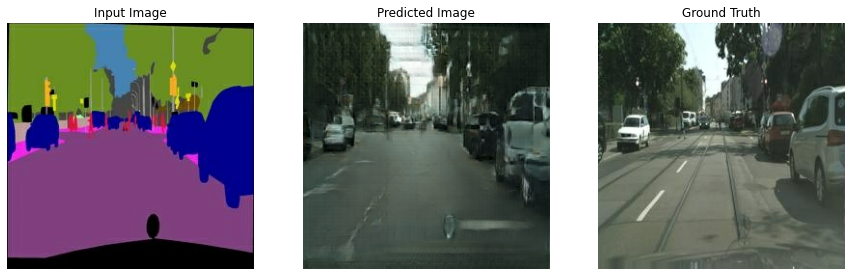

In [28]:
# val 폴더에 있는 5개의 검증이미지로 모델 테스트

for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

* 어느정도 사물끼리 구분이 가능하게 채색이 완료된것을 볼 수 있습니다.

### Epochs 200 적용한 Loss와 이미지.

![20230528](https://github.com/JHyeok-Choi/AIFFEL/assets/119499530/0c7387b9-6a66-4592-9d4e-2158eb94b579)

In [29]:
# epoch 200 설정한 데이터 로드
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


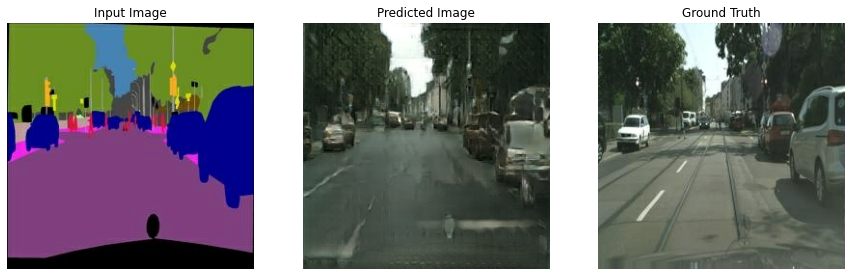

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


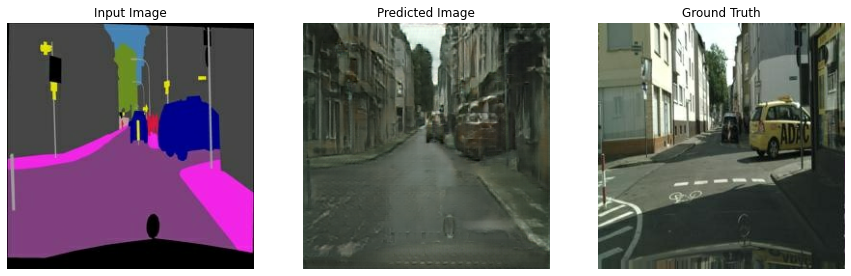

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


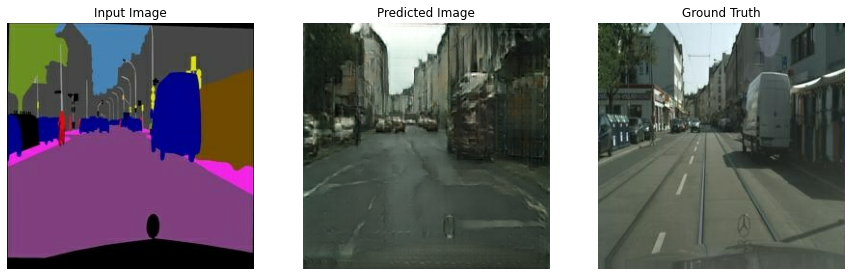

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


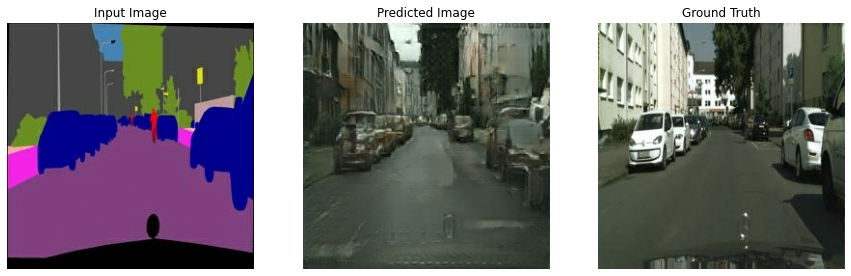

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [30]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

# 회고

* Segmentation 된 이미지를 입력받아 실제 이미지와 비슷하게 채색된 이미지를 생성해내는 pix2pix라는 cGAN 구축 및 훈련 해보는 프로젝트입니다.
* train image는 논문에서 사용한 Cityscape지만 해당 논문에서는 2975개의 이미지로 200 epoch를 했지만, 그보다 적은 1000개 50 epoch와 200 epoch에 batch_size 1, optimizer Adam의 learning rate 0.0002, beta_1 = 0.5, beta_2 = 0.999로 논문에서 명시된 수치를 반영했습니다.
* 50 epoch와 200 epoch를 비교할 때, epoch를 늘린만큼 개선되었다고 보긴 힘들것 같습니다.
* 200 epoch의 경우 훈련 진행중 70000 step 근처부터 Generator의 Loss가 점점 증가하여 2배 이상 증가하기도 하며, Discriminator의 Loss에도 일정하지 않은 변화가 보이니 이 시점에서 오버피팅이 생겨 이 이상의 훈련 진행은 데이터나 모델의 개선 후 진행해봐야 할것 같습니다.
* train image에 있는 자동차들이 대체적으로 어두운색이라서 채색된 자동차들도 대부분 어두운색으로 나온것, 같은 자동차로 segmentation 됬지만 위로 긴 탑차같은 경우 상대적으로 승용차들이 많아서 그런지 채색된 이미지에서는 자동차를 여러개 쌓아놓것 같이 되어 있는 요소 등 segmentation해서 같은 객체로 분류되어 그런지, 여러 방향이나 색깔, 형태 등에 맞게 표현하는것이 자유로운 점이 흥미로웠습니다.

### 참고
https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko